In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
# FUNÇAO QUE CONVERTE O FORMATO DO dtEVENTO NO ARQUIVO BASE_TREINAMENTO.CSV
# O FORMATO DAS DATAS NO CSV É DIFERENTE DAQUELE QUE ESTA NO NOME DOS ARQUIVOS
def timeConverter(DataFrame):
    dtEvento = []
    for i in range(0, 6966):
        aux = DataFrame.iloc[i, 4].replace(' ', '_')
        aux = aux.replace('-', '')
        dtEvento.append(aux.replace(':', ''))
        
    return dtEvento

# FUNÇAO QUE CONVERTE OS VALORES DE STRING PARA FLOAT
# OS DADOS DISPONIBILIZADOS ESTÃO TODOS EM TXT
def stringToFloat(dataFrame, nome):
    dataFrame[nome] = pd.to_numeric(dataFrame[nome], downcast="float")

    
# FUNÇAO QUE OBTEM OS DADOS DE CORRENTE RMS DE CADA UMA DAS ASSINATURAS
def getDados(Leitura, tipoDeDado):
    f = open(Leitura) # pode ser adicionado o .txt, mas ele ja esta presente nas colunas
    lines = f.readlines()
    i = 0
    while(i < len(lines)):
        i += 1
        if(lines[i] == "***End_of_Header***\n"):
            break
    
    Inicio = i + 2
    with open(Leitura) as f:
        linhas = f.readlines()[Inicio:]
    df = pd.DataFrame(linhas)
    df = df[0].str.split('\t', expand=True)
    stringToFloat(df, 2)
    
    if(tipoDeDado == 'tempo'):
        return np.array(df[0])
    if(tipoDeDado == 'corrente'):
        return np.array(df[1])
    if(tipoDeDado == 'correnteRMS'):
        return np.array(df[2])
    
def getLeituras(maquinas, amostragem, maquinaAnalisada):
    for i in range(0, int(len(maquinas.index))):  
        try:
            leitura = getDados(maquinas['DS_LOCAL_INSTALACAO'].iloc[i] + '/' + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt', 'correnteRMS')
        except FileNotFoundError:
            print("Leitura não encontrada: " + maquinas['DS_ATIVO_SAP'].iloc[i] + '_'  + maquinas['DS_POS_CMD'].iloc[i]  + '_' + maquinas['DT_EVENTO'].iloc[i] + '.txt')
        #else:
        DF = pd.DataFrame(leitura, columns=[maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i]])
        stringToFloat(DF, maquinas['DS_ATIVO_SAP'].iloc[i] + '_' + maquinas['DT_EVENTO'].iloc[i])
        DF = DF.transpose()
        maquinaAnalisada = pd.concat([maquinaAnalisada, DF,])
    maquinaAnalisada = maquinaAnalisada.transpose()
        
    return maquinaAnalisada
        

In [4]:
# Filtro de dados

# FUNÇAO QUE FILTRA AS LEITURAS ZERADAS OU QUE APRESENTAM COMPORTAMENTO DE PEQUENOS RUIDOS
# EXEMPLO DE LEITURA EM QUE ISSO ACONTECE: MCH004W21A_R_20190906_104250
def filtroLeiturasRuido(Maquinas):
    max = 0
    leiturasRuido = []
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 1):
            leiturasRuido.append(Maquinas.columns[i])
        max = 0
    
    Maquinas = Maquinas.drop(leiturasRuido, axis=1)
    return Maquinas 

# FUNÇAO QUE CORRIGE AS LEITURAS CUJAS CORRENTES SOFRERAM A REDUÇAO PELO FILTRO QUE O GUILHERME COMENTOU
def corrigeCorrentes(Maquinas, fatorDeCorrecao):
    max = 0
    aux = 0
    i = 0
    for i in range(1, len(Maquinas.columns)):
        for j in range(0, len(Maquinas.index)):
            if(max <= Maquinas.iloc[j, i]):
                max = Maquinas.iloc[j, i]
        if(max < 12):
            Maquinas[Maquinas.columns[i]] = fatorDeCorrecao*Maquinas[Maquinas.columns[i]]
        max = 0

    return Maquinas

# FILTRO DE LEITURAS DESLOCADAS PARA TRAÇAR A MEDIA
# Se o filtro não é utilizado, as curvas médias apresentam um comportamento bizarro, as médias não consideram deslocamento
def filtroLeituraDeslocada(leituras, dfPontosFase):
    leiturasFiltradas = []
    if(dfPontosFase.iloc[0,0] != None):
        moda = dfPontosFase.mode(axis=1)
        
        for i in range(0, len(dfPontosFase.columns)):
            if(dfPontosFase.iloc[0, i] > moda.iloc[0,0]*1.1 or dfPontosFase.iloc[0, i] < moda.iloc[0,0]/1.1): # filtra leituras cujo valor de fim da fase 0 é 40% maior que o valor mínimo
                leiturasFiltradas.append(dfPontosFase.columns[i])

        leituras = leituras.drop(leiturasFiltradas, axis=1)
    else:
        print('Não há leituras normais')
    return leituras

In [5]:
# Cálculos e plotagem de Dados

def Derivada(valor, intervalo):
    derivada = np.diff(valor.values)/intervalo    #pode ser alterado pra utilizar a coluna do tempo ao inves de um intervalo 
    return derivada
    pd.set_option('display.max_rows', 300)
    
def calculaFases(corrente, intervalo):
    deriv = np.array(Derivada(corrente, intervalo))
    corrente = np.array(corrente)
    fimFases = []
    fimFase0 = np.argmax(deriv[50:]>10) + 50
    fimFases.append(fimFase0)
    topo = 0
    topo = np.argmax(deriv[fimFase0:]<0)
    topo = topo + fimFase0
    
    metadeCorrente = np.argmax(corrente[topo:]<(corrente[topo]/2))  + topo
    fimFase1 = np.argmax(deriv[metadeCorrente + 1:]>-4)
    fimFase1 = fimFase1 + metadeCorrente + int(0.04545/intervalo)
    fimFases.append(fimFase1)
    #
    #descomentar quado se tratar de leituras novas
    #result = np.where(deriv[fimFase1 + int(0.15/intervalo):] == np.amin(deriv[fimFase1 + int(0.15/intervalo):fimFase1 + int(0.5/intervalo)]))
    #fimFase2 = result[0][0] + int(0.04/intervalo) + fimFase1 + int(0.15/intervalo)
    #fimFases.append(fimFase2)
    result = np.where(deriv == np.amax(deriv[fimFase1 + int(0.9/intervalo):fimFase1 + int(2/intervalo)]))
    fimFase3 = result[0][0] - int(0.04040/intervalo)
    fimFases.append(fimFase3)
    

    fimCorrente = np.argmax(corrente[fimFase3:]<(corrente[topo]/20)) + fimFase3
    fimFase4 = np.argmax(deriv[fimCorrente + 1:] > -1)
    fimFase4 = fimCorrente + fimFase4 - int(0.02020/intervalo)
    fimFases.append(fimFase4)
    return (fimFases)

# FUNÇAO QUE GERA UM GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
def geraAssinaturaMedia(maquinaEmAnalise, parametroStd):
    assinaturaNormal = pd.DataFrame()
    dfex = maquinaEmAnalise
    assinaturaNormal = assinaturaNormal.assign(Tempo = lambda x: dfex['t (s)']) 
    dfex = dfex.drop("t (s)", axis=1)
    stdNormal = dfex.std(axis=1)
    mediaNormal = dfex.mean(axis=1)
    assinaturaNormal['Std'] = stdNormal
    assinaturaNormal['Média'] = mediaNormal
    assinaturaNormal['Curva mínima'] = mediaNormal - parametroStd*stdNormal
    assinaturaNormal['Curva máxima'] = mediaNormal + parametroStd*stdNormal
    dfex.shape
    for i in range(0, len(assinaturaNormal.index)):
        if(assinaturaNormal.iloc[i, 3] < 0):
            assinaturaNormal.iloc[i, 3] = 0
      
    return assinaturaNormal

def plotaMarcado(corrente, fimDeFase, Leitura):
    corrente.plot(kind='line')
    plt.annotate('fim da fase 0', xy=(fimDeFase[0], corrente.iloc[fimDeFase[0]]), xytext=(1000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 1', xy=(fimDeFase[1], corrente.iloc[fimDeFase[1]]), xytext=(1100, 2.5), arrowprops=dict(facecolor='black', shrink=0.05),)
    #plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(1300, 5), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 2', xy=(fimDeFase[2], corrente.iloc[fimDeFase[2]]), xytext=(4000, 7), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.annotate('fim da fase 3', xy=(fimDeFase[3], corrente.iloc[fimDeFase[3]]), xytext=(6000, 2), arrowprops=dict(facecolor='black', shrink=0.05),)
    plt.title(Leitura)
    plt.show()
#Exemplo de uso:
#leitura = 'MCH006W21B_20200204_094643'
#plotaMarcado(maquinasPorEstado[1][leitura], dfPontosFase[leitura], leitura)


def subtraiMedia(leituras, inicio, final, media, distanciaFases, i):
    dist = total = 0
    for j in range(inicio, final):
        dist += (leituras.iloc[j, i] - media)**2
        if(j == final-1):
            distanciaFases.append(dist/(final))
            total += dist
            dist = 0
    return total

def eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i):
    dist = 0
    for k in range(0,3):
        if(dfPontosFase.iloc[k+1, i-1] > dfPontosFase.iloc[k, i-1]):
            fragNormal = normal['Média'][int(pontosMedia['Fim da Fase ' + str(k)]): int(pontosMedia['Fim da Fase ' + str(k)]) + (int(dfPontosFase.iloc[k+1, i-1]) - int(dfPontosFase.iloc[k, i-1]))]
            fragNormal = fragNormal.to_numpy()
            fragLeitura = leituras[col][dfPontosFase.iloc[k, i-1]: dfPontosFase.iloc[k+1, i-1]]
            fragLeitura = fragLeitura.to_numpy()
            subtraction = np.subtract(fragNormal, fragLeitura)
            power = np.power(subtraction,2)
            dist += np.sum(power, axis=0)
            distanciaFases.append(dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1]))
            total += dist/(dfPontosFase.iloc[k+1, i-1] - dfPontosFase.iloc[k, i-1])
            dist = 0
        else:
            print('Falha: ' + col)
            distanciaFases.append(0)
            total += 0
    return total

def calculaEQM (normal, leituras, dfPontosFase, pontosMedia, mediaInicio, mediaFim, amostragem):
    distanciasDF = pd.DataFrame(index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'])
    distanciasDF = distanciasDF.transpose()
    distanciaFases = []
    dist = total = 0
    i = 1
    
    for col in leituras.columns:
        if(col != 't (s)'):
            total += subtraiMedia(leituras, 0, dfPontosFase.iloc[0, i-1], mediaInicio, distanciaFases, i)
            total += eqmPorFase(normal, leituras, dfPontosFase, distanciaFases, pontosMedia, total, col, i)
            total += subtraiMedia(leituras, dfPontosFase.iloc[3, i-1], len(leituras.index), mediaFim, distanciaFases, i)

            distanciaFases.append(total/amostragem)
            total = 0

            DF = pd.DataFrame(distanciaFases,index =['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4', 'EQM Total'], columns=[leituras.columns[i]])
            DF = DF.transpose()
            distanciaFases = []
            distanciasDF = pd.concat([distanciasDF, DF,])
            i += 1

    distanciasDF = distanciasDF.transpose()
    return distanciasDF

In [6]:
pd.options.display.max_rows = 8200
pd.options.display.max_columns = 4000
amostragem = 8182

baseDF = pd.read_csv('BASE_TREINAMENTO.csv', sep=",")
dt = timeConverter(baseDF)
fabricantes = baseDF.DS_FABRICANTE.unique()

print('Lista de fabricantes: ')
fabricantes = pd.DataFrame(fabricantes, columns=['Nomes'])
fabricantes

Lista de fabricantes: 


Nomes
0  KY SLNS-1A
1    KY NS-AM

In [7]:
# Para escolher qual delas analisar, basta trocar o valor da variável abaixo
fabricante = fabricantes.iloc[0,0]

dtEvento = pd.DataFrame(dt, columns=['DT_EVENTO'])
baseDF = baseDF.assign(DT_EVENTO=dtEvento['DT_EVENTO'])
maquinas = baseDF.loc[(baseDF["DS_FABRICANTE"] == fabricante)]

dt = getDados('H004/MCH004W21A_N_20190817_190721.txt', 'tempo')
maquinaAnalisada = pd.DataFrame(dt, columns=['t (s)']) 
stringToFloat(maquinaAnalisada, 't (s)')
maquinaAnalisada = maquinaAnalisada.transpose()

In [8]:
%%time
maquinasSemDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Sem Defeito']
maquinasSemDefeito = maquinasSemDefeito.loc[maquinasSemDefeito['DS_ATIVO_SAP'] != 'MCH007W21B']
maquinasDefeito = maquinas.loc[maquinas["DS_ESTADO"] == 'Defeito']
maquinasDefeito = maquinasDefeito.loc[maquinasDefeito['DS_ATIVO_SAP'] != 'MCH007W21B']
maquinasFalha = maquinas.loc[maquinas["DS_ESTADO"] == 'Falha']

maquinasPorEstado = []
maquinasPorEstado.append(getLeituras(maquinasSemDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasDefeito, amostragem, maquinaAnalisada))
maquinasPorEstado.append(getLeituras(maquinasFalha, amostragem, maquinaAnalisada))

Leitura não encontrada: MCH004W22A_N_20200428_051834.txt
Leitura não encontrada: MCH009W22A_R_20200428_234342.txt
Leitura não encontrada: MCH012W22A_N_20200428_091742.txt
Leitura não encontrada: MCH012W22A_R_20200428_095708.txt
Leitura não encontrada: MCH012W22A_N_20200428_112521.txt
Leitura não encontrada: MCH012W22A_N_20200428_175139.txt
CPU times: user 3min 23s, sys: 1min 26s, total: 4min 50s
Wall time: 5min


In [9]:
%%time
# Tratamento e correção de dados
for i in range(0,3):  
    maquinasPorEstado[i] = filtroLeiturasRuido(maquinasPorEstado[i])
    
fatorDeCorrecao = 1.53 # o fator de correçao ainda é um valor estimado, não foi um dado fornecido pela Vale
for i in range(0,3):  
    maquinasPorEstado[i] = corrigeCorrentes(maquinasPorEstado[i], fatorDeCorrecao)

CPU times: user 9min 55s, sys: 833 ms, total: 9min 56s
Wall time: 9min 57s


In [16]:
%%time
# Cálculo dos fins de fase
PontosFase = []
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for rotulo in range(0, 3):
    for col in maquinasPorEstado[rotulo]:
        if (col != 't (s)'):
            pontos = calculaFases(maquinasPorEstado[rotulo][col], 0.00101)
            dfPontosFase[col] = pontos
    PontosFase.append(dfPontosFase)
    dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

CPU times: user 3.66 s, sys: 8.06 ms, total: 3.67 s
Wall time: 3.67 s


In [126]:
def calculaTamanhoFases(dfPontosFase):
    tamanhoFasesMin = []
    tamanhoFasesMax = []
    dfPontosFase = dfPontosFase.transpose()
    for i in range(0, 3):
        bloco_1 = dfPontosFase['Fim da Fase ' +  str(i)]
        bloco_2 = dfPontosFase['Fim da Fase ' + str(i+1)]
        subtract = np.where((bloco_2 > bloco_1), bloco_2.sub(bloco_1),np.nan)
        sub = pd.DataFrame(subtract)
        minimum = sub.min(axis=0)
        maximum = sub.max(axis=0)
        tamanhoFasesMin.append(minimum)
        tamanhoFasesMax.append(maximum)
    tamanho = pd.DataFrame(tamanhoFasesMax)
    tamanhoFases = pd.DataFrame(tamanhoFasesMin)
    tamanhoFases = pd.concat([tamanhoFases, tamanho], axis=1)
        
    return tamanhoFases 

In [143]:
def detectaFalha(dfPontosFase, tamanho):
    for i in range(0, len(dfPontosFase.columns)):
        controle = True
        for k in range(0, len(dfPontosFase.index)-1):
            if(dfPontosFase.iloc[k+1, i] <= dfPontosFase.iloc[k, i]):
                controle = False
            elif(((dfPontosFase.iloc[k+1, i] - dfPontosFase.iloc[k, i]) < tamanho.iloc[k,0]) | ((dfPontosFase.iloc[k+1, i] - dfPontosFase.iloc[k, i]) > tamanho.iloc[k,1])):
                controle = False
        if(controle == False):
            print('Falha: ' +  dfPontosFase.columns[i])

In [146]:
tamanhoFasesNormal = calculaTamanhoFases(PontosFase[0])
detectaFalha(PontosFase[1], tamanhoFasesNormal)

Falha: MCH004W22A_20190817_194821
Falha: MCH004W22A_20190818_074507
Falha: MCH004W22A_20190818_092727
Falha: MCH004W22A_20190818_140246
Falha: MCH004W22A_20190819_063839
Falha: MCH004W22A_20190820_045829
Falha: MCH004W22A_20190820_075138
Falha: MCH004W22A_20190820_152036
Falha: MCH004W22A_20190820_201418
Falha: MCH004W22A_20190821_091504
Falha: MCH004W22A_20190821_101835
Falha: MCH004W22A_20190822_051604
Falha: MCH004W22A_20190822_162617
Falha: MCH004W22A_20190822_170609
Falha: MCH004W22A_20190823_191104
Falha: MCH004W22A_20190823_203917
Falha: MCH004W22A_20190824_065409
Falha: MCH004W22A_20190824_212135
Falha: MCH004W22A_20190824_222223
Falha: MCH004W22A_20190824_233242
Falha: MCH004W22A_20190825_000810
Falha: MCH004W22A_20190825_005207
Falha: MCH004W22A_20190825_192346
Falha: MCH004W22A_20190825_200157
Falha: MCH004W22A_20190825_205745
Falha: MCH004W22A_20190825_221621
Falha: MCH004W22A_20190826_000912
Falha: MCH008W21A_20190821_155740
Falha: MCH008W21A_20190820_093949
Falha: MCH008W

CPU times: user 356 ms, sys: 4.82 ms, total: 361 ms
Wall time: 359 ms


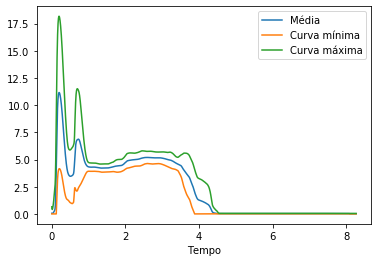

In [101]:
%%time
# SELECIONA DADOS E PLOTA O GRAFICO COM AS CURVAS MEDIA, MAXIMA E MINIMA
parametroStd = 1
normal = geraAssinaturaMedia(maquinasPorEstado[0], parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

CPU times: user 314 ms, sys: 12.5 ms, total: 327 ms
Wall time: 327 ms


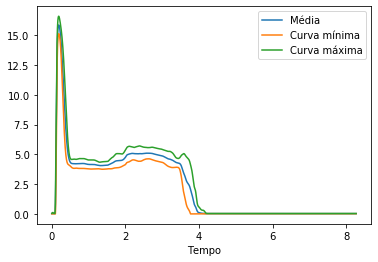

In [102]:
%%time
# MEDIA NORMAL COM FILTRO DE LEITURAS DESLOCADAS
normaisDeslocamentoFiltrado = filtroLeituraDeslocada(maquinasPorEstado[0], PontosFase[0])
parametroStd = 1
normal = geraAssinaturaMedia(normaisDeslocamentoFiltrado, parametroStd)

ax = plt.gca()
normal.plot(kind='line',x='Tempo',y='Média',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva mínima',ax=ax)
normal.plot(kind='line',x='Tempo',y='Curva máxima',ax=ax)

In [103]:
%%time
# CALCULA MEDIA DOS FINS DE CADA FASE PARA LEITURA NORMAL FILTRADA
dfPontosFase = pd.DataFrame(index =['Fim da Fase 0', 'Fim da Fase 1', 'Fim da Fase 2', 'Fim da Fase 3'])

for col in normaisDeslocamentoFiltrado:
    if (col != 't (s)'):
        pontos = calculaFases(normaisDeslocamentoFiltrado[col], 0.00101)
        dfPontosFase[col] = pontos


#calcula os pontos de troca de fase da assinatura
pontosMediaFilt = dfPontosFase.mean(axis=1)
print (pontosMediaFilt)

# Esse bloco calcula uma media dos valores normais para a fase inicial para ser comparada com as leituras em
# analise, a escolha desse metodo serve para contornar os casos em que o inicio da fase 1 esta deslocado.
mediaInicio = mediaFim = 0

for c in range(0, int(pontosMediaFilt.iloc[0])):
    mediaInicio += normal.iloc[c, 2]
mediaInicio = mediaInicio/int(pontosMediaFilt.iloc[0])
    
# Esse bloco e analogo ao primeiro, fazendo o mesmo processo mas para a fase final
for d in range(int(pontosMediaFilt.iloc[3]), amostragem):
    mediaFim += normal.iloc[d, 2]
mediaFim = mediaFim/int(pontosMediaFilt.iloc[3])

Fim da Fase 0      91.719588
Fim da Fase 1     525.311340
Fim da Fase 2    1790.208247
Fim da Fase 3    3756.917526
dtype: float64
CPU times: user 285 ms, sys: 2.04 ms, total: 287 ms
Wall time: 286 ms


In [153]:
%%time
# Cálculo dos erros quadráticos médios
eqmNormal = calculaEQM(normal, maquinasPorEstado[0], PontosFase[0], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmNormal = eqmNormal.transpose()
eqmNormal['rotulo'] = 0
eqmDefeito = calculaEQM(normal, maquinasPorEstado[1], PontosFase[1], pontosMediaFilt, mediaInicio, mediaFim, amostragem)
eqmDefeito = eqmDefeito.transpose()
eqmDefeito['rotulo'] = 1
eqmFalha = calculaEQM(normal, maquinasPorEstado[2], PontosFase[2], pontosMediaFilt, mediaInicio, mediaFim, amostragem)

CPU times: user 4min 30s, sys: 524 ms, total: 4min 31s
Wall time: 4min 31s


EQM Fase 0  EQM Fase 1  EQM Fase 2  EQM Fase 3  \
MCH004W21A_20190820_041558   89.820709   21.317580    0.093925    0.273233   
MCH004W21A_20190820_070907   87.048599   21.111946    0.100935    0.277453   
MCH004W21A_20190821_030949   82.862976   23.780192    0.090829    0.233585   
MCH004W21A_20190825_221621    1.795378    4.293859    0.070177    0.249949   
MCH004W21A_20190825_223820    1.068076    4.022596    0.075483    0.311846   
MCH004W21B_20190824_051910    0.000037    2.138219    0.025434    0.481410   
MCH004W21B_20190824_223933    0.000019    1.603322    0.025934    0.946639   
MCH004W21B_20190821_030949    0.000028    3.520609    0.047066    0.403521   
MCH004W22A_20190824_223933    0.000110    1.399731    0.207022    1.099751   
MCH004W22A_20190825_235713    0.000172    1.836179    0.204166    0.843793   
MCH004W22B_20190818_065920    0.000029    0.457494    0.047230    0.409453   
MCH004W22B_20190821_084825    0.000019    0.636449    0.040410    0.463161   
MCH004W22B_20190821_100534    0.000015    0.643811    0.047623    0.389931   
MCH004W22B_20190823_173930    0.000016    0.559210    0.076043    0.396480   
MCH004W22B_20190823_195740    0.000013    0.612296    0.079437    0.431399   
MCH004W22B_20190824_052012    0.000017    0.656124    0.046085    0.372469   
MCH004W22B_20190824_215423    0.000020    0.628568    0.064053    0.405949   
MCH004W22B_20190824_223933    0.000143    0.503070    0.058959    0.496264   
MCH004W22B_20190825_235713    0.000026    0.561653    0.047393    0.385566   
MCH007W22B_20190821_092821    0.000011    0.776379    0.114086    0.356805   
MCH007W22B_20190821_230619    0.000014    0.812217    0.090710    0.330945   
MCH007W22B_20190824_141732    0.000009    1.027419    0.158600    0.400364   
MCH007W22B_20190824_141818    0.000066    1.011254    0.158577    0.323097   
MCH007W22B_20190824_162331    0.000067    0.887841    0.067303    0.359892   
MCH007W22B_20190824_193104    0.000038    0.907287    0.106641    0.363643   
MCH007W22B_20190824_194201    0.000073    1.028767    0.230907    0.485680   
MCH007W22B_20190825_012853    0.000048    1.066369    0.100394    0.324348   
MCH007W22B_20190825_023857    0.000065    0.965719    0.101980    0.290632   
MCH007W22B_20190825_050119    0.000066    0.924953    0.103448    0.368938   
MCH007W22B_20190825_073719    0.000030    1.002295    0.104150    0.333381   
MCH007W22B_20190825_091024    0.000043    1.027622    0.153763    0.353728   
MCH007W22B_20190825_092802    0.000060    1.151249    0.085703    0.254490   
MCH007W22B_20190825_123706    0.000024    1.147351    0.105509    0.282532   
MCH007W22B_20190825_161814    0.000031    1.067089    0.096881    0.275336   
MCH007W22B_20190825_185626    0.000067    0.988240    0.111930    0.365491   
MCH007W22B_20190825_222414    0.000028    1.010086    0.115208    0.317976   
MCH007W22B_20190824_201137    0.000039    0.707205    0.073388    0.302633   
MCH007W22B_20190825_043741    0.000036    0.871186    0.076396    0.265358   
MCH007W22B_20190825_061111    0.000035    1.084623    0.091017    0.299940   
MCH007W22B_20190825_080621    0.000017    1.032023    0.077733    0.263165   
MCH007W22B_20190825_094223    0.000097    0.994176    0.079108    0.240369   
MCH007W22B_20190825_153752    0.000020    0.864034    0.080971    0.265745   
MCH008W21A_20190805_110550    0.000029    0.859790    0.039477    0.344051   
MCH008W21A_20190805_111727    0.000063    0.764124    0.033082    0.319023   
MCH008W21A_20190821_100342    0.000011    0.714813    0.037298    0.314095   
MCH008W21A_20190821_133904    0.000109    0.721350    0.036696    0.319844   
MCH008W21A_20190821_145521    0.000042    0.673479    0.031044    0.353721   
MCH008W21A_20190821_190223    0.000019    0.763169    0.031812    0.319832   
MCH008W21A_20190822_143428    0.000011    0.809740    0.032883    0.341951   
MCH008W21A_20190822_160251    0.000040    0.850624    0.035861    0.367606   
MCH008W21A_20190823_102739    0.000062    0.913967

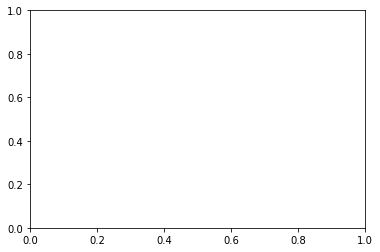

In [246]:
index = []
for i in range(0, len(eqmNormal)):
    index.append(i)
ind = pd.DataFrame(index, index=eqmNormal.index, columns=['# Leituras'])
eqm = pd.concat([eqmNormal, ind], axis=1)
#eqmNormal
ax = plt.gca()
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 0',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 1',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 2',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 3',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 4',ax=ax)
#eqm

EQM Fase 0  EQM Fase 1  EQM Fase 2  EQM Fase 3  \
MCH004W21A_20190817_190721  3.855830e-05    0.548705    0.092400    0.975041   
MCH004W21A_20190818_040348  1.340759e-05    0.737027    0.091792    0.645262   
MCH004W21A_20190818_075539  7.741808e-05    0.717982    0.097922    0.809664   
MCH004W21A_20190818_133100  3.251366e-05    0.826388    0.074783    0.686386   
MCH004W21A_20190822_200934  1.455684e-05    0.905990    0.103993    0.905572   
MCH004W21A_20190823_173930  7.798247e-05    0.586354    0.092358    0.692607   
MCH004W21A_20190824_051909  2.139053e-05    0.783035    0.100402    0.389314   
MCH004W21A_20190824_184528  1.200431e-05    0.558505    0.084465    0.868327   
MCH004W21A_20190824_213645  5.641778e-06    0.770084    0.102956    0.672279   
MCH004W21A_20190824_223933  3.076717e-05    0.495442    0.096327    0.591790   
MCH004W21A_20190824_235319  1.340647e-05    0.486048    0.094477    0.452271   
MCH004W21A_20190825_005137  6.884537e-05    0.601263    0.093255    0.540033   
MCH004W21A_20190825_142334  2.503803e-05    0.787409    0.087903    0.443262   
MCH004W21A_20190825_192011  6.960323e-05    0.599124    0.091309    0.494187   
MCH004W21A_20190825_195416  1.145651e-04    0.528925    0.096617    0.602432   
MCH004W21A_20190825_204352  8.850281e-05    0.596013    0.098486    0.511301   
MCH004W21A_20190825_223046  1.628678e-05    0.594997    0.093830    0.356445   
MCH004W21A_20190825_232708  8.728099e-05    0.700340    0.101642    0.404303   
MCH004W21A_20190826_001602  6.100657e-05    0.640060    0.093203    0.296493   
MCH004W21A_20190819_160400  1.950001e+00    3.912241    0.145902    0.312196   
MCH004W21A_20190820_170120  2.824430e+00    4.921061    0.075852    0.394202   
MCH004W21A_20190822_194528  2.525243e+01   12.131416    0.061923    0.300201   
MCH004W21A_20190823_172414  3.711098e+00    5.464183    0.062991    0.290604   
MCH004W21A_20190824_050529  6.164770e+00    7.450118    0.082335    0.253225   
MCH004W21A_20190824_182713  2.003759e+01   10.906142    0.070650    0.329595   
MCH004W21A_20190824_212135  6.186171e-01    2.187116    0.078259    0.278878   
MCH004W21A_20190824_222223  2.330242e+01   10.379450    0.088245    0.302542   
MCH004W21A_20190825_000810  2.587950e+00    4.588721    0.076570    0.332713   
MCH004W21A_20190825_140457  3.857716e+01   13.100067    0.096116    0.302977   
MCH004W21A_20190825_184714  4.889022e+01   14.418162    0.068004    0.274681   
MCH004W21A_20190825_192346  4.658054e+01   15.124945    0.071525    0.305798   
MCH004W21A_20190825_200157  6.981734e+00    7.068965    0.070158    0.358221   
MCH004W21A_20190826_000913  1.213793e+01    9.916043    0.078378    0.258378   
MCH004W21B_20190819_085707  1.006593e-04    1.886864    0.033871    1.389152   
MCH004W21B_20190819_164236  3.633060e-05    1.580829    0.042767    2.891004   
MCH004W21B_20190822_200934  4.189419e-05    1.870093    0.029205    2.110054   
MCH004W21B_20190823_173930  5.028133e-05    1.584162    0.028548    0.773139   
MCH004W21B_20190824_184528  7.928064e-05    1.654671    0.026383    2.156010   
MCH004W21B_20190824_213645  5.278520e-05    2.026560    0.029112    1.209093   
MCH004W21B_20190824_235319  2.699473e-05    1.608087    0.028074    0.567360   
MCH004W21B_20190825_005137  1.057827e-04    1.560628    0.029010    0.988125   
MCH004W21B_20190825_142334  6.273635e-05    1.717228    0.034619    0.841249   
MCH004W21B_20190825_192011  1.805881e-05    1.757252    0.021595    1.055879   
MCH004W21B_20190825_195416  2.304600e-05    1.577368    0.026435    1.204185   
MCH004W21B_20190825_204352  3.052523e-05    1.592733    0.026154    1.104507   
MCH004W21B_20190825_223046  9.185296e-05    1.873624    0.018373    0.471120   
MCH004W21B_20190825_232708  8.549388e-05    1.822401    0.027981    0.609763   
MCH004W21B_20190826_001602  9.852991e-06    2.284397    0.023950    0.462318   
MCH004W21B_20190817_185048  3.438764e-05    2.829970    0.074727    1.583231   
MCH004W21B_20190822_194528  1.

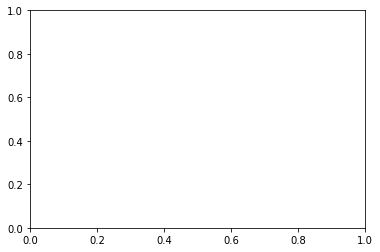

In [247]:
index = []
for i in range(0, len(eqmDefeito)):
    index.append(i)
ind = pd.DataFrame(index, index=eqmDefeito.index, columns=['# Leituras'])
eqm = pd.concat([eqmDefeito, ind], axis=1)
#eqmDefeito
ax = plt.gca()
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 0',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 1',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 2',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 3',ax=ax)
#eqm.plot(kind='line',x='# Leituras',y='EQM Fase 4',ax=ax)
#eqm

In [361]:
# junta os dataframes de normal e defeito
if(len(eqmNormal.index) > len(eqmDefeito.index)):
    principal = pd.concat([eqmNormal.sample(n=len(eqmDefeito)), eqmDefeito]) #.sample(n=len(eqmDefeito))
else:
    principal = pd.concat([eqmNormal, eqmDefeito.sample(n=len(eqmNormal))])
#principal

EQM Fase 0  EQM Fase 1  EQM Fase 2  EQM Fase 3  \
MCH004W21A_20190820_041558   89.820709   21.317580    0.093925    0.273233   
MCH004W21A_20190820_070907   87.048599   21.111946    0.100935    0.277453   
MCH004W21A_20190821_030949   82.862976   23.780192    0.090829    0.233585   
MCH004W21A_20190825_221621    1.795378    4.293859    0.070177    0.249949   
MCH004W21A_20190825_223820    1.068076    4.022596    0.075483    0.311846   
MCH004W21B_20190824_051910    0.000037    2.138219    0.025434    0.481410   
MCH004W21B_20190824_223933    0.000019    1.603322    0.025934    0.946639   
MCH004W21B_20190821_030949    0.000028    3.520609    0.047066    0.403521   
MCH004W22A_20190824_223933    0.000110    1.399731    0.207022    1.099751   
MCH004W22A_20190825_235713    0.000172    1.836179    0.204166    0.843793   
MCH004W22B_20190818_065920    0.000029    0.457494    0.047230    0.409453   
MCH004W22B_20190821_084825    0.000019    0.636449    0.040410    0.463161   
MCH004W22B_20190821_100534    0.000015    0.643811    0.047623    0.389931   
MCH004W22B_20190823_173930    0.000016    0.559210    0.076043    0.396480   
MCH004W22B_20190823_195740    0.000013    0.612296    0.079437    0.431399   
MCH004W22B_20190824_052012    0.000017    0.656124    0.046085    0.372469   
MCH004W22B_20190824_215423    0.000020    0.628568    0.064053    0.405949   
MCH004W22B_20190824_223933    0.000143    0.503070    0.058959    0.496264   
MCH004W22B_20190825_235713    0.000026    0.561653    0.047393    0.385566   
MCH007W22B_20190821_092821    0.000011    0.776379    0.114086    0.356805   
MCH007W22B_20190821_230619    0.000014    0.812217    0.090710    0.330945   
MCH007W22B_20190824_141732    0.000009    1.027419    0.158600    0.400364   
MCH007W22B_20190824_141818    0.000066    1.011254    0.158577    0.323097   
MCH007W22B_20190824_162331    0.000067    0.887841    0.067303    0.359892   
MCH007W22B_20190824_193104    0.000038    0.907287    0.106641    0.363643   
MCH007W22B_20190824_194201    0.000073    1.028767    0.230907    0.485680   
MCH007W22B_20190825_012853    0.000048    1.066369    0.100394    0.324348   
MCH007W22B_20190825_023857    0.000065    0.965719    0.101980    0.290632   
MCH007W22B_20190825_050119    0.000066    0.924953    0.103448    0.368938   
MCH007W22B_20190825_073719    0.000030    1.002295    0.104150    0.333381   
MCH007W22B_20190825_091024    0.000043    1.027622    0.153763    0.353728   
MCH007W22B_20190825_092802    0.000060    1.151249    0.085703    0.254490   
MCH007W22B_20190825_123706    0.000024    1.147351    0.105509    0.282532   
MCH007W22B_20190825_161814    0.000031    1.067089    0.096881    0.275336   
MCH007W22B_20190825_185626    0.000067    0.988240    0.111930    0.365491   
MCH007W22B_20190825_222414    0.000028    1.010086    0.115208    0.317976   
MCH007W22B_20190824_201137    0.000039    0.707205    0.073388    0.302633   
MCH007W22B_20190825_043741    0.000036    0.871186    0.076396    0.265358   
MCH007W22B_20190825_061111    0.000035    1.084623    0.091017    0.299940   
MCH007W22B_20190825_080621    0.000017    1.032023    0.077733    0.263165   
MCH007W22B_20190825_094223    0.000097    0.994176    0.079108    0.240369   
MCH007W22B_20190825_153752    0.000020    0.864034    0.080971    0.265745   
MCH008W21A_20190805_110550    0.000029    0.859790    0.039477    0.344051   
MCH008W21A_20190805_111727    0.000063    0.764124    0.033082    0.319023   
MCH008W21A_20190821_100342    0.000011    0.714813    0.037298    0.314095   
MCH008W21A_20190821_133904    0.000109    0.721350    0.036696    0.319844   
MCH008W21A_20190821_145521    0.000042    0.673479    0.031044    0.353721   
MCH008W21A_20190821_190223    0.000019    0.763169    0.031812    0.319832   
MCH008W21A_20190822_143428    0.000011    0.809740    0.032883    0.341951   
MCH008W21A_20190822_160251    0.000040    0.850624    0.035861    0.367606   
MCH008W21A_20190823_102739    0.000062    0.913967

In [ ]:
# Regressão

In [535]:
# divide em dataframe de treino e teste
c = 0.05
train, test = train_test_split(principal, random_state=0)

# configura as features a ser analisadas, e treina o modelo
feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4'] #'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4'
X_treino = train.loc[:, feature_cols]
y_treino = train.rotulo
X_teste = test.loc[:, feature_cols]
y_teste = test.rotulo
modelo = LogisticRegression(C = c)
modelo.fit(X_treino, y_treino)
    
porcentagens = []
#porcentagens.append('{:.2f}'.format(modelo.score(X_treino, y_treino)))
#porcentagens.append('{:.2f}'.format(modelo.score(X_teste, y_teste)))  

porcentagens.append(modelo.score(X_treino, y_treino))
porcentagens.append(modelo.score(X_teste, y_teste))

porcent = pd.DataFrame(porcentagens, index =['Treino', 'Teste'], columns=['%'])

for i in range(1, 1000):
    train, test = train_test_split(principal, random_state=i)

    # configura as features a ser analisadas, e treina o modelo
    feature_cols = ['EQM Fase 0', 'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4'] #'EQM Fase 1', 'EQM Fase 2', 'EQM Fase 3', 'EQM Fase 4'
    X_treino = train.loc[:, feature_cols]
    y_treino = train.rotulo
    X_teste = test.loc[:, feature_cols]
    y_teste = test.rotulo
    modelo = LogisticRegression(C = c)
    modelo.fit(X_treino, y_treino)
    
    porcentagens = []
    
    porcentagens.append(modelo.score(X_treino, y_treino))
    porcentagens.append(modelo.score(X_teste, y_teste))
    
    porc = pd.DataFrame(porcentagens, index =['Treino', 'Teste'], columns=['%'])
    porcent = pd.concat([porcent, porc], axis=1)
    porcentagens = []

porcent

%         %         %         %         %         %         %  \
Treino  0.794074  0.788148  0.782963  0.788148  0.781481  0.787407  0.789630   
Teste   0.755556  0.762222  0.793333  0.771111  0.793333  0.777778  0.771111   

               %         %         %         %         %         %         %  \
Treino  0.785926  0.786667  0.785185  0.782222  0.777037  0.790370  0.782963   
Teste   0.777778  0.766667  0.768889  0.800000  0.802222  0.766667  0.791111   

               %         %         %         %         %         %         %  \
Treino  0.781481  0.794074  0.782963  0.780000  0.793333  0.780741  0.786667   
Teste   0.780000  0.757778  0.784444  0.784444  0.755556  0.786667  0.775556   

               %         %         %         %         %         %         %  \
Treino  0.778519  0.785926  0.786667  0.772593  0.784444  0.792593  0.785926   
Teste   0.800000  0.780000  0.782222  0.806667  0.786667  0.757778  0.782222   

               %         %         %         %         %         %         %  \
Treino  0.785185  0.793333  0.778519  0.785185  0.778519  0.787407  0.787407   
Teste   0.775556  0.755556  0.793333  0.773333  0.791111  0.771111  0.773333   

               %         %         %         %         %         %         %  \
Treino  0.786667  0.789630  0.777778  0.782963  0.769630  0.787407  0.782963   
Teste   0.775556  0.762222  0.804444  0.793333  0.824444  0.771111  0.782222   

               %         %         %         %         %         %         %  \
Treino  0.798519  0.777778  0.784444  0.777037  0.788889  0.779259  0.778519   
Teste   0.740000  0.813333  0.780000  0.802222  0.764444  0.791111  0.791111   

               %         %         %         %         %         %         %  \
Treino  0.773333  0.785926  0.780741  0.773333  0.780741  0.790370  0.784444   
Teste   0.808889  0.782222  0.791111  0.815556  0.782222  0.748889  0.780000   

               %         %         %         %         %         %         %  \
Treino  0.785926  0.785185  0.788148  0.783704  0.784444  0.774074  0.791111   
Teste   0.775556  0.777778  0.777778  0.777778  0.780000  0.811111  0.771111   

               %         %         %         %         %         %         %  \
Treino  0.786667  0.782963  0.791852  0.782963  0.795556  0.785185  0.792593   
Teste   0.775556  0.786667  0.762222  0.782222  0.744444  0.793333  0.762222   

               %         %         %         %         %         %         %  \
Treino  0.783704  0.778519  0.782222  0.786667  0.792593  0.789630  0.782222   
Teste   0.784444  0.793333  0.786667  0.771111  0.755556  0.762222  0.788889   

               %         %         %         %         %         %         %  \
Treino  0.794074  0.781481  0.795556  0.774074  0.782222  0.782963  0.782963   
Teste   0.748889  0.802222  0.753333  0.811111  0.786667  0.780000  0.791111   

               %         %         %         %         %         %         %  \
Treino  0.780000  0.785926  0.783704  0.793333  0.787407  0.795556  0.782222   
Teste   0.788889  0.775556  0.768889  0.762222  0.784444  0.762222  0.793333   

               %         %         %         %         %         %         %  \
Treino  0.782222  0.786667  0.782963  0.782222  0.798519  0.783704  0.782963   
Teste   0.795556  0.773333  0.791111  0.788889  0.740000  0.788889  0.791111   

               %         %         %         %         %         %         %  \
Treino  0.784444  0.778519  0.783704  0.788889  0.785185  0.785185  0.791111   
Teste   0.782222  0.800000  0.788889  0.773333  0.771111  0.782222  0.764444   

               %         %         %         %         %         %         %  \
Treino  0.781481  0.794815  0.776296  0.784444  0.785185  0.786667  0.777778   
Teste   0.793333  0.753333  0.800000  0.766667  0.777778  0.777778  0.802222   

               %         %         %         %         %         %         %  \
Treino  0.793333  0.783704  0.788148  0.790370  0.782222  0.791111  0.784444   

In [536]:
mean = porcent.mean(axis=1)
mean

Treino    0.783938
Teste     0.782609
dtype: float64

In [537]:
std = porcent.std(axis=1)
std

Treino    0.005769
Teste     0.017027
dtype: float64

In [276]:
classific = pd.DataFrame(y_teste)
pred = pd.DataFrame(predictions, index=y_teste.index)
pred = pd.concat([pred, classific], axis=1)
pred

0         1  rotulo
MCH007W22A_20190902_235620  3.554532e-01  0.644547       1
MCH010W21B_20191121_123151  5.420929e-01  0.457907       1
MCH008W22A_20191203_051903  7.588854e-01  0.241115       0
MCH009W21A_20190904_120744  4.367408e-01  0.563259       1
MCH008W21B_20190826_153843  7.839847e-01  0.216015       0
MCH007W22B_20190826_072706  6.109134e-01  0.389087       0
MCH010W22A_20190905_230358  6.532711e-01  0.346729       0
MCH009W22A_20200202_052926  6.949643e-01  0.305036       0
MCH004W22B_20190826_143053  5.986994e-01  0.401301       0
MCH004W21A_20200403_063419  6.082525e-01  0.391748       0
MCH008W22B_20190827_212743  2.213048e-01  0.778695       1
MCH007W22B_20190824_193251  6.472736e-01  0.352726       1
MCH010W22B_20190906_183608  2.695813e-01  0.730419       1
MCH007W21A_20190826_071804  5.275559e-01  0.472444       1
MCH007W22B_20200406_223319  6.289208e-01  0.371079       1
MCH012W22B_20200407_061331  7.316835e-01  0.268317       1
MCH008W22B_20191030_171849  6.685148e-01  0.331485       0
MCH007W21A_20190821_132021  4.642970e-01  0.535703       1
MCH008W22A_20190825_090707  7.478954e-01  0.252105       0
MCH004W22A_20190909_143225  6.133083e-01  0.386692       1
MCH008W22B_20190906_180311  5.783422e-01  0.421658       0
MCH010W22A_20190901_063317  6.487232e-01  0.351277       0
MCH007W21B_20200205_115749  8.665015e-01  0.133499       0
MCH007W22B_20190825_185626  6.403399e-01  0.359660       0
MCH009W22B_20190828_072937  4.819649e-03  0.995180       1
MCH004W22B_20200331_095254  6.373433e-01  0.362657       0
MCH007W22B_20190822_060010  6.110761e-01  0.388924       1
MCH007W21B_20190930_004006  9.833181e-01  0.016682       0
MCH010W22A_20190904_090638  4.447411e-01  0.555259       1
MCH009W21B_20190825_200213  4.668547e-01  0.533145       1
MCH007W22B_20190825_094223  6.707841e-01  0.329216       0
MCH007W22B_20190901_033358  6.227781e-01  0.377222       1
MCH004W21A_20190826_000913  9.891651e-01  0.010835       1
MCH009W21A_20190826_015311  4.255296e-01  0.574470       1
MCH009W22B_20200118_082846  2.649515e-01  0.735049       0
MCH010W22B_20190824_222825  2.269605e-01  0.773040       1
MCH011W22A_20200205_142803  7.041966e-02  0.929580       1
MCH010W22B_20190910_043127  3.508764e-01  0.649124       1
MCH010W22A_20190902_134354  5.026791e-01  0.497321       1
MCH007W22A_20190904_101720  2.432418e-01  0.756758       1
MCH009W21A_20190908_034539  4.473836e-01  0.552616       1
MCH007W21B_20190907_070514  8.578680e-01  0.142132       1
MCH007W21A_20200218_121852  1.241848e-01  0.875815       1
MCH007W21B_20200204_155457  5.368471e-01  0.463153       1
MCH010W22A_20190829_040811  5.829692e-01  0.417031       1
MCH008W22A_20190826_083632  7.500058e-01  0.249994       0
MCH009W21B_20190909_181110  4.063137e-01  0.593686       1
MCH011W22B_20200204_112531  2.539402e-02  0.974606       1
MCH009W21B_20190906_133844  3.896195e-01  0.610381       0
MCH008W21B_20190909_154506  6.443329e-01  0.355667       0
MCH007W21B_20190827_104705  8.883873e-01  0.111613       0
MCH007W22A_20190819_231727  2.480075e-01  0.751992       1
MCH007W22B_20190825_123706  6.773298e-01  0.322670       0
MCH008W22A_20190825_150328  6.100015e-01  0.389999       0
MCH009W22A_20200422_144109  6.559153e-01  0.344085       0
MCH008W22A_20190827_172916  7.279814e-01  0.272019       0
MCH009W21A_20200401_174212  5.755978e-01  0.424402       1
MCH010W22B_20190902_102721  7.656097e-02  0.923439       1
MCH004W22B_20191129_100212  6.411187e-01  0.358881       0
MCH010W22A_20190909_185616  5.487525e-01  0.451248       0
MCH004W21B_20190831_030528  7.420613e-01  0.257939       1
MCH008W22B_20190831_115516  2.445487e-03  0.997555       1
MCH008W22B_20190805_043900  6.214582e-01  0.378542       1
MCH008W21A_20190830_093252  5.944898e-01  0.405510       0
MCH008W22A_20190903_120614  7.216697e-01  0.278330       0
MCH010W22A_20190903_150250  3.524213e-01  0.647579       1
MCH009W22A_20190826_004304  7.792252e-01  0.220775       0
MCH010W22B_20190904_082902 

In [254]:
X_treino.shape

(750, 5)

In [266]:
predictions = modelo.predict_proba(X_teste)

In [267]:
predictions

array([[3.55453200e-01, 6.44546800e-01],
       [5.42092942e-01, 4.57907058e-01],
       [7.58885377e-01, 2.41114623e-01],
       ...,
       [3.50365067e-01, 6.49634933e-01],
       [2.99387175e-01, 7.00612825e-01],
       [7.49412760e-04, 9.99250587e-01]])

In [214]:
#X_teste

In [215]:
#y_teste

In [134]:
modelo.get_params()

{'C': 0.05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [258]:
print (modelo.coef_)

[[ 0.34443482 -0.42597506  0.68057032  0.99171611  0.36631223]]


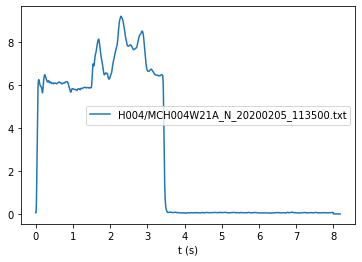

In [149]:
# Plotagem de leituras individuais para análise
house = 'H004' #MCH008W22B_20190904_210551 MCH011W22B_20191226_181448 MCH004W21A_20200205_113500
tipoDeMaquina = 'MCH004W21A' 
configuracao = 'N'
leitura = '20200205_113500'

Leitura = house + '/' + tipoDeMaquina + '_' + configuracao + '_' + leitura + '.txt'
dt = getDados('H006/MCH006W22B_N_20191014_132901.txt', 'tempo')
selecionadas = pd.DataFrame()
selecionadas['t (s)'] = dt
stringToFloat(selecionadas, 't (s)')
selecionadas = selecionadas.transpose()
leituras = getDados(Leitura, 'correnteRMS')
DF = pd.DataFrame(leituras, columns=[Leitura])
stringToFloat(DF, Leitura)

max = 0
for j in range(0, len(DF.index)):
    if(max <= DF.iloc[j, 0]):
        max = DF.iloc[j, 0]
    
if(max < 12):
    for j in range(0, len(DF.index)):
        aux = DF.iloc[j, 0]
        DF.iloc[j, 0] = aux*fatorDeCorrecao

DF = DF.transpose()
selecionadas = pd.concat([selecionadas, DF,])
selecionadas = selecionadas.transpose()

ax = plt.gca()
selecionadas.plot(kind='line',x='t (s)',y=Leitura,ax=ax)